In [13]:
import sys
sys.path.insert(0, '../../')  

import math
import numpy as np
import matplotlib.pyplot as plt 
from gasp import process_data_for_gasp, train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_simple, sampling, responses, SSFPParams

In [25]:
def AlphaSensitivityAnalysis_ensemble(D, model_ratios=[3.5, 10], alpha0 = 10, alpha1 = 90, Nx = 90):
    width = 256
    height = 1
    npcs = 16
    TRs = [5e-3, 10e-3, 20e-3]
    n_points = npcs * len(TRs)
    gradient = 2 * np.pi
    phantom_type = 'line'
    method = 'affine'
    Na = npcs * len(TRs) + 1
    Alpha = np.linspace(alpha0, alpha1, Nx)
    Alpha = np.deg2rad(Alpha)
    T2base = 0.1
    TRs, PCs = sampling.grid_TR_sampling(n_points=n_points, TRs=TRs)

    # Train
    A = np.zeros((Nx, Na), dtype=np.complex128)
    for i, alpha in enumerate(Alpha):
        params = SSFPParams(n_points, alpha, TRs, PCs)
        
        # Train an ensemble of models
        for j, ratio in enumerate(model_ratios):
            M = simulate_ssfp_simple(width=width, height=height, T1=T2base*ratio, T2 =T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
            Ic, An = train_gasp(M, D, method=method)
            A[i, :] = np.array(An)
        A[i, :] = A[i, :] / len(model_ratios)

    # Evaluate
    MSE_2D = np.zeros((Nx, Nx))
    for i, alpha_train in enumerate(Alpha):
        for j, alpha_data in enumerate(Alpha):
            params = SSFPParams(n_points, alpha_data, TRs, PCs)
            M = simulate_ssfp_simple(width=width, height=height, T1=T2base*ratio, T2 =T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
            I = run_gasp(M, A[i,:], method=method)
            MSE_2D[i,j] = np.sqrt(np.mean((np.abs(I) - D)**2))

    MSE_1D = MSE_2D.mean(axis=1)
    
    return MSE_2D, MSE_1D, Alpha, Alpha

In [14]:
def ShapeSensitivityAnalysis_ensemble(D, model_ratios=[3.5, 10], alpha0 = 5, alpha1 = 90, Nx = 50, rMin = 0.5, rMax = 20, Nr = 60):
    width = 256
    height = 1
    npcs = 16
    TRs = [5e-3, 10e-3, 20e-3]
    n_points = npcs * len(TRs)
    gradient = 2 * np.pi
    method = 'affine'
    Na = npcs * len(TRs) + 1
    Alpha = np.linspace(alpha0, alpha1, Nx)
    Alpha = np.deg2rad(Alpha)
    T2base = 0.1
    T1T2ratio = np.linspace(rMin, rMax, Nr)
    TRs, PCs = sampling.grid_TR_sampling(n_points=n_points, TRs=TRs)

    # Train - for each alpha, train an ensemble of models
    A = np.zeros((Nx, Na), dtype=np.complex128)
    for i, alpha in enumerate(Alpha):
        params = SSFPParams(n_points, alpha, TRs, PCs)

        # Train an ensemble of models
        for j, ratio in enumerate(model_ratios):
            M = simulate_ssfp_simple(width=width, height=height, T1=T2base*ratio, T2 =T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
            Ic, An = train_gasp(M, D, method=method)
            A[i, :] = A[i, :] + np.array(An)
        A[i, :] = A[i, :] / len(model_ratios)

    # Evaluate - for each alpha, evaluate the ensemble of models
    MSE_2D = np.zeros((Nx, Nr))
    for i, alpha_train in enumerate(Alpha):
        for j, ratio in enumerate(T1T2ratio):
            params = SSFPParams(n_points, alpha_train, TRs, PCs)
            M = simulate_ssfp_simple(width=width, height=height, T1=T2base*ratio, T2 =T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
            I = run_gasp(M, A[i,:], method=method)
            MSE_2D[i,j] = np.sqrt(np.mean((np.abs(I) - D)**2))

    MSE_1D = MSE_2D.mean(axis=1)
    
    return MSE_2D, MSE_1D, Alpha, T1T2ratio

In [16]:
def plotContour_MSE(MSE):
    from matplotlib import cm, ticker
    
    levels= np.linspace(MSE[0].min(), MSE[0].max(), 10)

    y = np.rad2deg(MSE[2])
    x = MSE[3]
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    cs = ax.contourf(X, Y, MSE[0], locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    cbar = fig.colorbar(cs)
    plt.ylabel(r'$\alpha_{train}$')
    plt.xlabel(r'T1 T2 ratio')
    plt.show()
    
    #plt.plot(y, np.log10(MSE[1]), 'r')
    #plt.show

In [17]:
width = 256
Nx = 50
Nr = 50
alpha0 = 5
alpha1 = 90

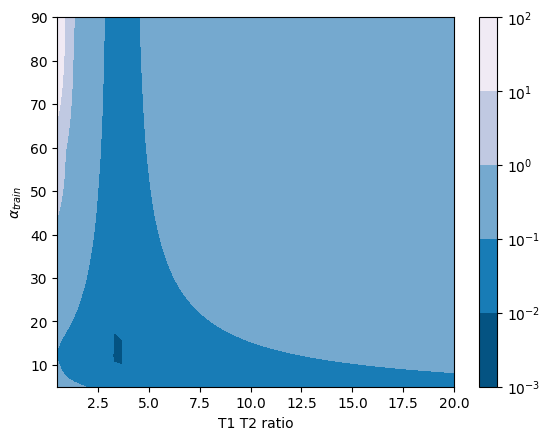

In [18]:
D = responses.bandpass_filter(width, bw=0.25, shift=0)
MSE = ShapeSensitivityAnalysis_ensemble(D, model_ratios=[3.5], alpha0 = alpha0, alpha1 = alpha1, Nx = Nx, Nr = Nr)
plotContour_MSE(MSE)

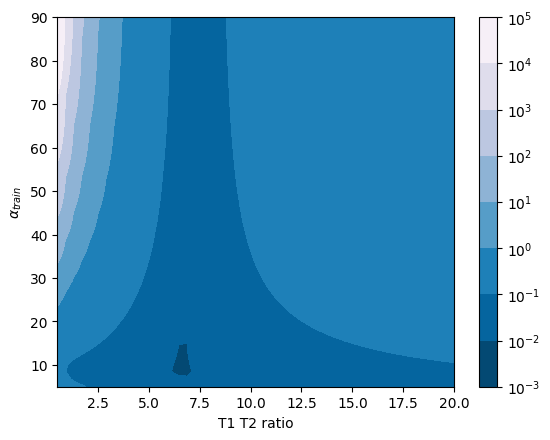

In [19]:
D = responses.bandpass_filter(width, bw=0.25, shift=0)
MSE = ShapeSensitivityAnalysis_ensemble(D, model_ratios=[3.5, 10], alpha0 = alpha0, alpha1 = alpha1, Nx = Nx, Nr = Nr)
plotContour_MSE(MSE)

In [26]:
D = responses.bandpass_filter(width, bw=0.25, shift=0)
MSE = AlphaSensitivityAnalysis_ensemble(D, model_ratios=[3.5, 10], alpha0 = alpha0, alpha1 = alpha1, Nx = Nx)
plotContour_MSE(MSE)


TypeError: AlphaSensitivityAnalysis_ensemble() got an unexpected keyword argument 'Nr'

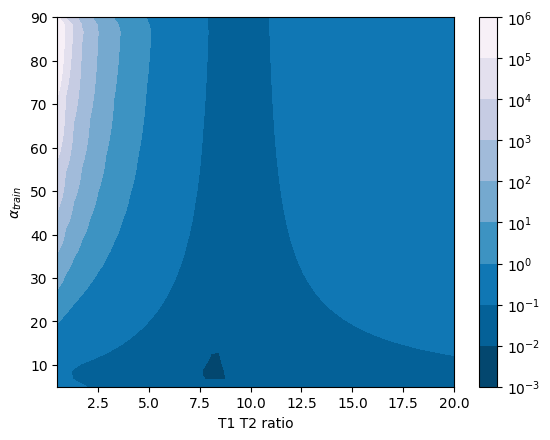

In [20]:
D = responses.bandpass_filter(width, bw=0.25, shift=0)
MSE = ShapeSensitivityAnalysis_ensemble(D, model_ratios=[3.5, 5, 10, 15], alpha0 = alpha0, alpha1 = alpha1, Nx = Nx, Nr = Nr)
plotContour_MSE(MSE)

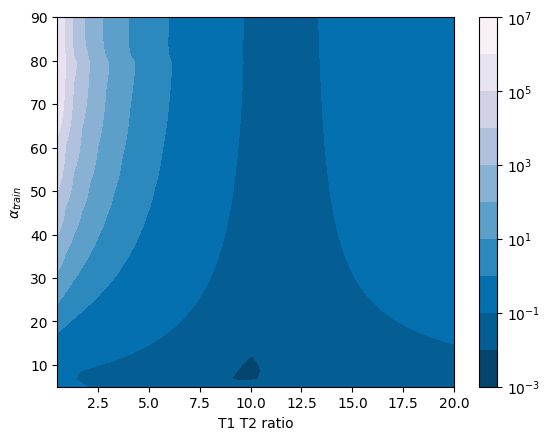

In [23]:
D = responses.bandpass_filter(width, bw=0.25, shift=0)
MSE = ShapeSensitivityAnalysis_ensemble(D, model_ratios=np.linspace(0.5, 20, 50), alpha0 = alpha0, alpha1 = alpha1, Nx = Nx, Nr = Nr)
plotContour_MSE(MSE)